# Задача
В этом задании вам предстоит ранжировать объявления для поиска.

Зачем вообще их ранжировать?
Поиск в Авито – трафикообразующая платформа для селлеров и незаменимый инструмент для покупателей. Если поисковая выдача будет нерелевантной, покупатели уйдут с площадки. Как и уйдут продавцы, если перестанут получать отклики и трафик на свои объявления.

Архитектура реальных поисковых систем обычно многостадийная: есть этап кандидатогенерации, работающий со всей базой объявлений, и есть этап реранкинга, поднимающий релевантных кандидатов выше в выдаче.

В задании предлагается разработать ML-модель для этапа реранкинга. Речь здесь идёт о небольшом числе объявлений, порядка десятков-сотен. Предполагается, что вы будете использовать классические методы машинного обучения

Коротко пройдемся по полям в наборе данных:

* query_id и item_id – идентификаторы поискового запроса и объявления соответственно. Пара (query_id, item_id) представляет собой одну 'точку' в наборе данных
* query_text, item_title, item_description – доступные вам текстовые данные. Текст запроса, заголовок и описание объявления
* query_cat, query_mcat, query_loc – некоторые категории запроса и его локация
* item_cat_id, item_mcat_id, item_loc – аналогичные поля для объявления
* price – цена, указанная в объявлении
* item_query_click_conv – статистика, некоторая конверсия из показа в клик у этого айтема по этому запросу
* item_contact – произошел ли у покупателя контакт с продавцом по этому айтему, колонка с таргетом. Естественно, она есть только в тренировочной выборке

Метрика
Качество ранжирования будет оцениваться по метрике NDCG@10, вики. На картинке ниже версия без нормализации:
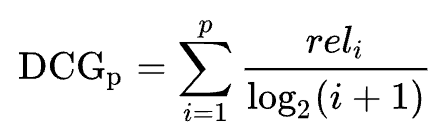

а практике, эффекта positional decay засчёт знаменателя можно добиться необязательно используя логарифм. В грейдере на степике метрика считается следующим образом, используя decay вида 0.97^position:



 import numpy as np


def calc_dcg_at_k(v: np.ndarray, k: int = 10) -> float:
    w = 0.97 ** np.arange(len(v))
    return (v * w)[:k].sum()


def calc_idcg_at_k(v: np.ndarray, k: int = 10) -> float:
    return calc_dcg_at_k(np.sort(v)[::-1], k)


def calc_ndcg_at_k(v: np.ndarray, k: int = 10) -> float:
    return calc_dcg_at_k(v, k) / calc_idcg_at_k(v, k)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from catboost import CatBoostRanker, Pool
from google.colab import drive
import gc

In [ ]:
from google.colab import drive
import pandas as pd
import os

# Подключаем Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузка данных

In [ ]:
BASE_COLUMNS = [
    "query_id",
    "item_id",
    "query_text",
    "item_title",
    "query_cat",
    "query_mcat",
    "query_loc",
    "item_cat_id",
    "item_mcat_id",
    "item_loc",
    "price",
    "item_query_click_conv",
    "item_contact",
]

train = pd.read_parquet(
    "/content/drive/MyDrive/DS_Avito/train-dset.parquet",
    columns=BASE_COLUMNS
)

test = pd.read_parquet(
    "/content/drive/MyDrive/DS_Avito/test-dset-small.parquet",
    columns=[c for c in BASE_COLUMNS if c != "item_contact"]
)


Безопасное извлечение признаков из item_description. Description слишком большой, поэтому нельзя читать целиком

In [ ]:
def extract_desc_features(parquet_path, total_rows):
    pf = pq.ParquetFile(parquet_path)

    desc_len = np.zeros(total_rows, dtype=np.int32)
    desc_words = np.zeros(total_rows, dtype=np.int32)

    pos = 0
    for rg in range(pf.num_row_groups):
        table = pf.read_row_group(rg, columns=["item_description"])
        s = table.column("item_description").to_pandas().fillna("").astype(str)

        n = len(s)
        desc_len[pos:pos+n] = s.str.len().values
        desc_words[pos:pos+n] = s.str.split().str.len().values

        pos += n
        del table, s
        gc.collect()

    return desc_len, desc_words

In [ ]:
train_desc_len, train_desc_words = extract_desc_features(
    "/content/drive/MyDrive/DS_Avito/train-dset.parquet",
    len(train)
)

train["desc_len"] = train_desc_len
train["desc_words"] = train_desc_words

In [ ]:
test_desc_len, test_desc_words = extract_desc_features(
    "/content/drive/MyDrive/DS_Avito/test-dset-small.parquet",
    len(test)
)

test["desc_len"] = test_desc_len
test["desc_words"] = test_desc_words

Базовая очистка данных

In [ ]:
for col in ["query_text", "item_title"]:
    train[col] = train[col].fillna("").astype(str)
    test[col] = test[col].fillna("").astype(str)

train["price"] = train["price"].fillna(train["price"].median())
test["price"] = test["price"].fillna(train["price"].median())

HashingVectorizer. Не хранит словарь, отсюда минимальное потребление RAM

In [ ]:
hv = HashingVectorizer(
    n_features=2**18,
    alternate_sign=False,
    norm="l2"
)

train_q = hv.transform(train["query_text"])
train_t = hv.transform(train["item_title"])
train["cos_q_title"] = (train_q.multiply(train_t)).sum(axis=1).A1

test_q = hv.transform(test["query_text"])
test_t = hv.transform(test["item_title"])
test["cos_q_title"] = (test_q.multiply(test_t)).sum(axis=1).A1


Простое пересечение слов

In [ ]:
def overlap_ratio(a, b):
    a = set(a.split())
    b = set(b.split())
    if not a:
        return 0.0
    return len(a & b) / len(a)

train["overlap_q_title"] = [
    overlap_ratio(a, b) for a, b in zip(train["query_text"], train["item_title"])
]

test["overlap_q_title"] = [
    overlap_ratio(a, b) for a, b in zip(test["query_text"], test["item_title"])
]


Категориальные и числовые признаки

In [ ]:
for df in [train, test]:
    df["cat_match"] = (df["query_cat"] == df["item_cat_id"]).astype(int)
    df["mcat_match"] = (df["query_mcat"] == df["item_mcat_id"]).astype(int)
    df["loc_match"] = (df["query_loc"] == df["item_loc"]).astype(int)
    df["log_price"] = np.log1p(df["price"]) # логарифм цены стабилизирует распределение

Финальный набор признаков

In [ ]:
FEATURES = [
    "cos_q_title",
    "overlap_q_title",
    "cat_match",
    "mcat_match",
    "loc_match",
    "log_price",
    "item_query_click_conv",
    "desc_len",
    "desc_words",
]

TARGET = "item_contact"
GROUP = "query_id"


Split по query_id

In [ ]:
q_train, q_val = train_test_split(
    train["query_id"].unique(),
    test_size=0.2,
    random_state=42
)

train_tr = train[train["query_id"].isin(q_train)].sort_values("query_id")
train_va = train[train["query_id"].isin(q_val)].sort_values("query_id")

X_train = train_tr[FEATURES]
y_train = train_tr[TARGET]
g_train = train_tr[GROUP]

X_val = train_va[FEATURES]
y_val = train_va[TARGET]
g_val = train_va[GROUP]


Обучение CatBoostRanker

In [ ]:
model = CatBoostRanker(
    iterations=700,
    learning_rate=0.1,
    depth=7,
    loss_function="YetiRank",
    eval_metric="NDCG:top=10",
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU",
    thread_count=2
)

train_pool = Pool(X_train, y_train, group_id=g_train)
val_pool = Pool(X_val, y_val, group_id=g_val)

model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)


0:	test: 0.7860266	best: 0.7860266 (0)	total: 11.7s	remaining: 2h 15m 51s
100:	test: 0.8196553	best: 0.8196553 (100)	total: 17m 27s	remaining: 1h 43m 34s
200:	test: 0.8201932	best: 0.8202331 (195)	total: 34m 31s	remaining: 1h 25m 42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8202334037
bestIteration = 227

Shrink model to first 228 iterations.


Предсказание и формирование итогового файла

In [ ]:
test["score"] = model.predict(test[FEATURES])

submission = (
    test
    .sort_values(["query_id", "score"], ascending=[True, False])
    [["query_id", "item_id"]]
)

submission.to_csv("solution.csv", index=False)